In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import scipy.stats as stats
from time import perf_counter


### Import data

In [226]:
originalDataX = pd.read_csv('data/Data_X.csv')
originalDataY = pd.read_csv('data/Data_Y.csv')
originalDataNew = pd.read_csv('data/DataNew_X.csv')

In [227]:
# Merge X and Y

df = pd.merge(originalDataX, originalDataY, on='ID')


### Data Preparation


In [228]:
# Remove unnecessary columns

df = df.drop(['ID'], axis=1)

In [229]:
# Print and Remove duplicated values

print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


0


In [230]:
# Delete null and missing values
print("Before: ", df.isnull().sum().sum())
df = df.dropna()
print("After: ", df.isnull().sum().sum())


Before:  1002
After:  0


In [231]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


df.head()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
1,501,1,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,687,1,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,720,0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
5,467,1,-0.295296,-0.765120,-0.717490,0.717490,-1.117139,-0.200305,1.117139,0.200305,...,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457,0.932105
6,144,1,-0.234965,-0.677085,0.399588,-0.399588,0.183998,-0.986235,-0.183998,0.986235,...,-1.658394,-0.529800,-0.318920,-1.220760,-0.512991,0.147507,1.889739,0.498226,0.681739,0.192680


In [232]:
# Scale data
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)


# minmax = MinMaxScaler()
# df = pd.DataFrame(minmax.fit_transform(df), columns=df.columns)


### Data Exploration

In [233]:
# Shape
print(df.shape)

(1276, 35)


In [234]:
# List columns
print(df.columns)

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DAY_ID            1276 non-null   float64
 1   COUNTRY           1276 non-null   float64
 2   DE_CONSUMPTION    1276 non-null   float64
 3   FR_CONSUMPTION    1276 non-null   float64
 4   DE_FR_EXCHANGE    1276 non-null   float64
 5   FR_DE_EXCHANGE    1276 non-null   float64
 6   DE_NET_EXPORT     1276 non-null   float64
 7   FR_NET_EXPORT     1276 non-null   float64
 8   DE_NET_IMPORT     1276 non-null   float64
 9   FR_NET_IMPORT     1276 non-null   float64
 10  DE_GAS            1276 non-null   float64
 11  FR_GAS            1276 non-null   float64
 12  DE_COAL           1276 non-null   float64
 13  FR_COAL           1276 non-null   float64
 14  DE_HYDRO          1276 non-null   float64
 15  FR_HYDRO          1276 non-null   float64
 16  DE_NUCLEAR        1276 non-null   float64


In [236]:
# Describe data
df.describe()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
count,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,1.276000e+03,1276.000000,1.276000e+03,...,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03
mean,-5.011665e-17,2.784258e-17,2.227407e-17,-8.352775e-18,3.341110e-17,-3.341110e-17,0.000000,-1.670555e-17,0.000000,1.670555e-17,...,-4.176388e-18,-1.670555e-17,-2.227407e-17,-1.113703e-17,-1.461736e-17,2.088194e-17,5.568517e-18,-2.784258e-18,-6.960646e-18,6.960646e-18
std,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392,1.000392e+00,1.000392,1.000392e+00,...,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00
min,-1.716719e+00,-1.068148e+00,-3.935100e+00,-1.563610e+00,-2.779043e+00,-2.836752e+00,-2.273731,-2.473398e+00,-2.637059,-1.868037e+00,...,-2.102481e+00,-1.637178e+00,-1.929982e+00,-1.957380e+00,-4.835521e+00,-5.807410e+00,-4.853030e+00,-5.285234e+00,-3.885727e+00,-6.174637e+00
25%,-8.662014e-01,-1.068148e+00,-6.523718e-01,-7.260343e-01,-8.426723e-01,-8.119140e-01,-0.765993,-7.194953e-01,-0.745633,-8.391713e-01,...,-6.097163e-01,-4.978426e-01,-7.497091e-01,-7.723324e-01,-6.596832e-01,-6.804778e-01,-6.407556e-01,-4.853747e-01,-5.467853e-01,-3.168912e-01
50%,-6.915172e-03,9.362001e-01,-1.155892e-01,-4.137645e-01,3.415595e-02,-3.415595e-02,-0.069932,1.538248e-01,0.069932,-1.538248e-01,...,-2.501298e-01,-2.288674e-01,-3.389462e-01,-3.091014e-01,-4.747208e-02,-4.389808e-02,-5.670151e-02,5.468462e-03,-3.345362e-02,-9.232470e-02
75%,8.647927e-01,9.362001e-01,7.563681e-01,6.387449e-01,8.119140e-01,8.426723e-01,0.745633,8.391713e-01,0.765993,7.194953e-01,...,3.615018e-01,1.369363e-01,5.397517e-01,7.347676e-01,6.585257e-01,6.923387e-01,5.686704e-01,5.758137e-01,4.666275e-01,1.791461e-01
max,1.822722e+00,9.362001e-01,2.512826e+00,2.979626e+00,2.836752e+00,2.779043e+00,2.637059,1.868037e+00,2.273731,2.473398e+00,...,7.825238e+00,8.962924e+00,4.574479e+00,4.456830e+00,3.021213e+00,2.810828e+00,5.031304e+00,3.486939e+00,4.830851e+00,7.183013e+00


In [237]:
# Variance
df.var()

DAY_ID              1.000784
COUNTRY             1.000784
DE_CONSUMPTION      1.000784
FR_CONSUMPTION      1.000784
DE_FR_EXCHANGE      1.000784
FR_DE_EXCHANGE      1.000784
DE_NET_EXPORT       1.000784
FR_NET_EXPORT       1.000784
DE_NET_IMPORT       1.000784
FR_NET_IMPORT       1.000784
DE_GAS              1.000784
FR_GAS              1.000784
DE_COAL             1.000784
FR_COAL             1.000784
DE_HYDRO            1.000784
FR_HYDRO            1.000784
DE_NUCLEAR          1.000784
FR_NUCLEAR          1.000784
DE_SOLAR            1.000784
FR_SOLAR            1.000784
DE_WINDPOW          1.000784
FR_WINDPOW          1.000784
DE_LIGNITE          1.000784
DE_RESIDUAL_LOAD    1.000784
FR_RESIDUAL_LOAD    1.000784
DE_RAIN             1.000784
FR_RAIN             1.000784
DE_WIND             1.000784
FR_WIND             1.000784
DE_TEMP             1.000784
FR_TEMP             1.000784
GAS_RET             1.000784
COAL_RET            1.000784
CARBON_RET          1.000784
TARGET        

In [238]:
# Print target mean by country

print(df.groupby('COUNTRY')['TARGET'].mean())

COUNTRY
-1.068148    0.057226
 0.936200   -0.050157
Name: TARGET, dtype: float64


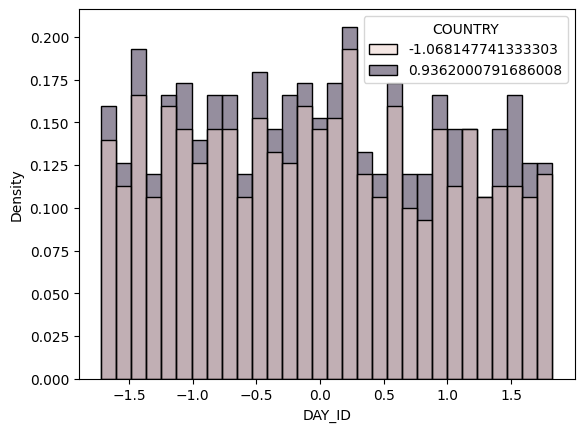

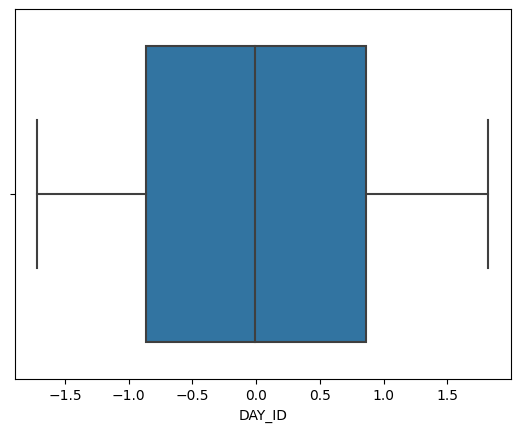

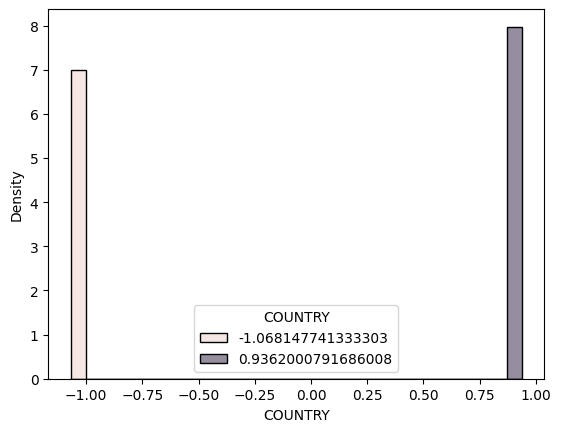

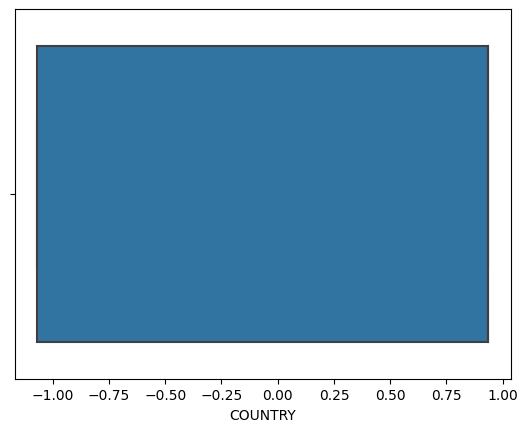

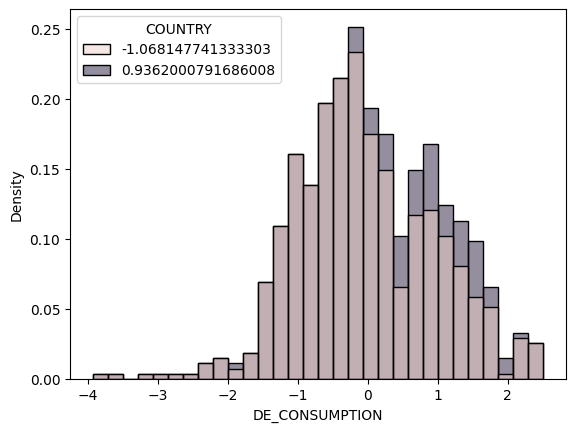

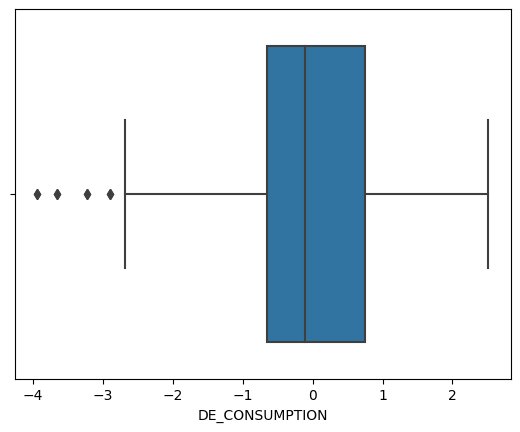

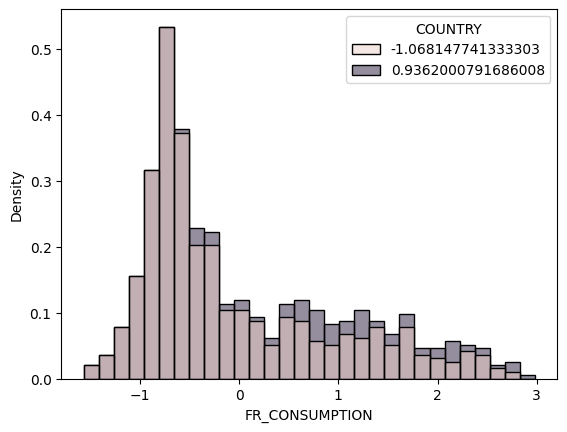

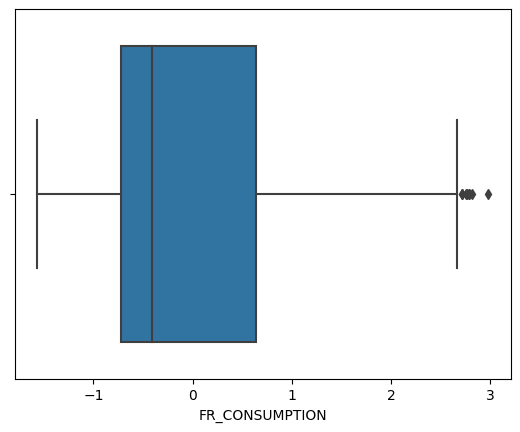

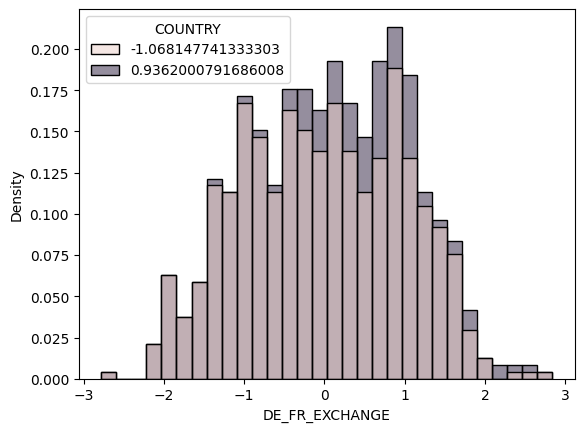

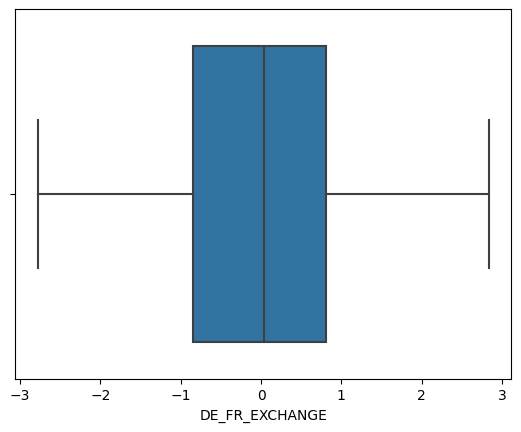

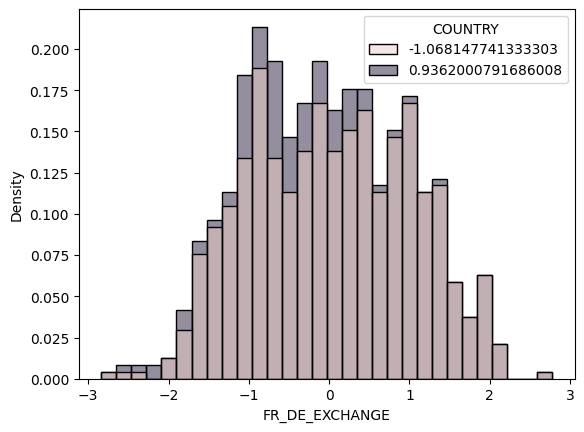

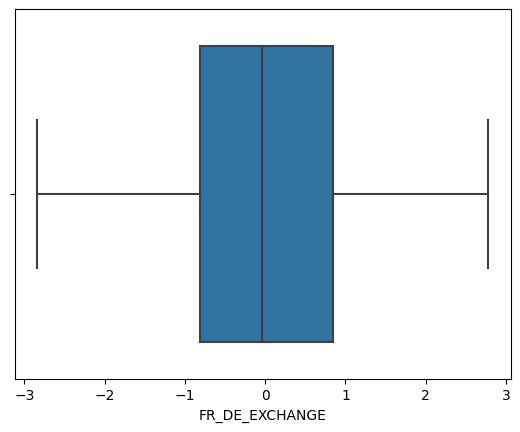

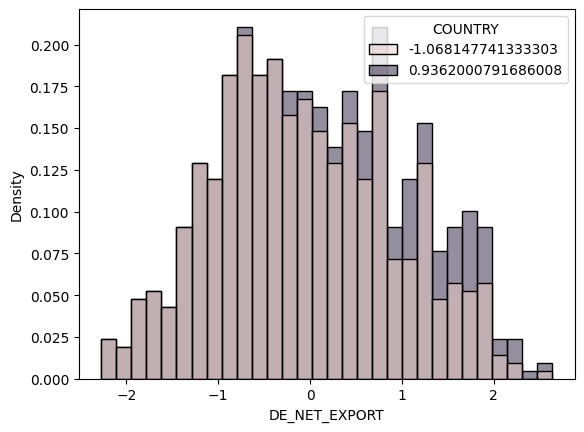

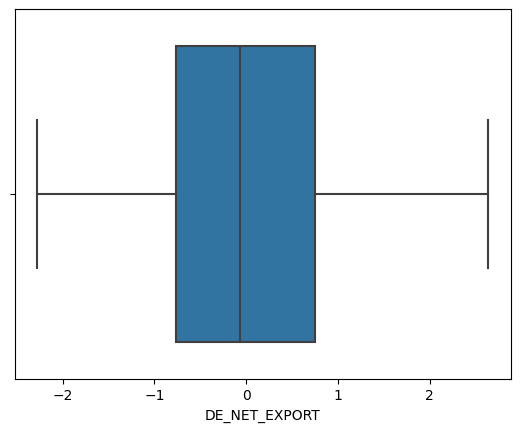

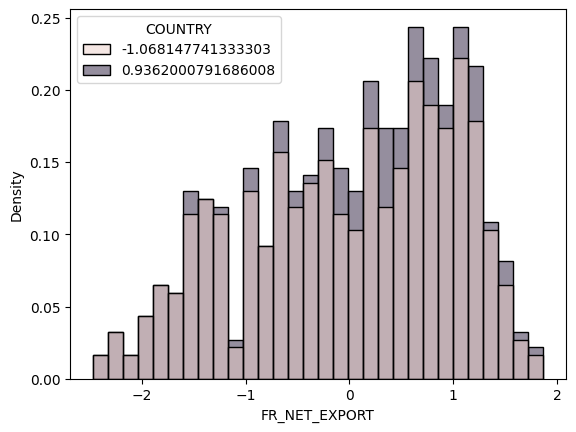

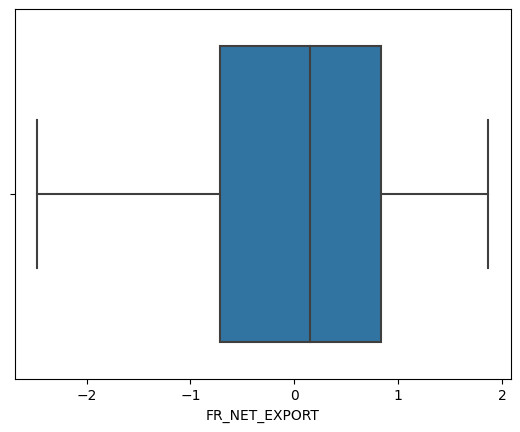

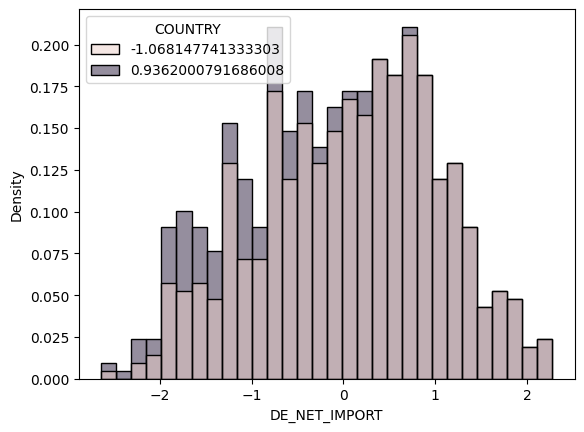

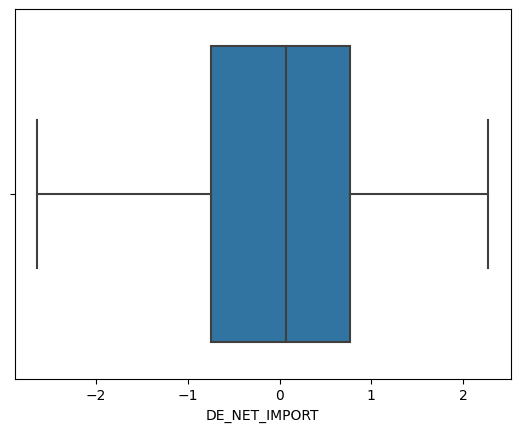

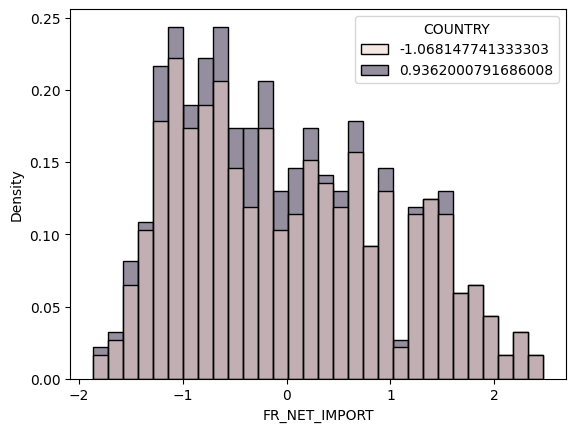

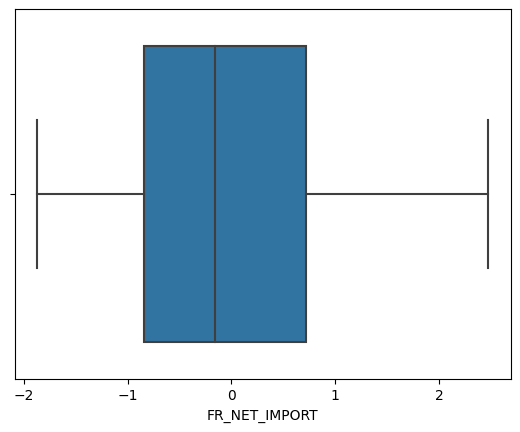

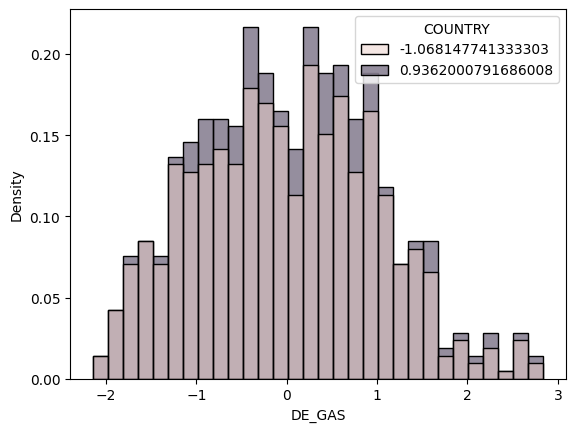

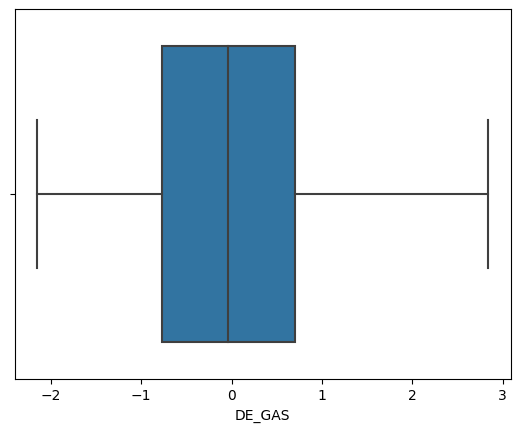

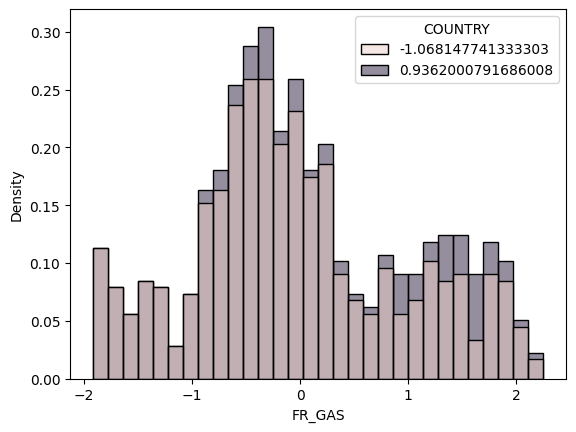

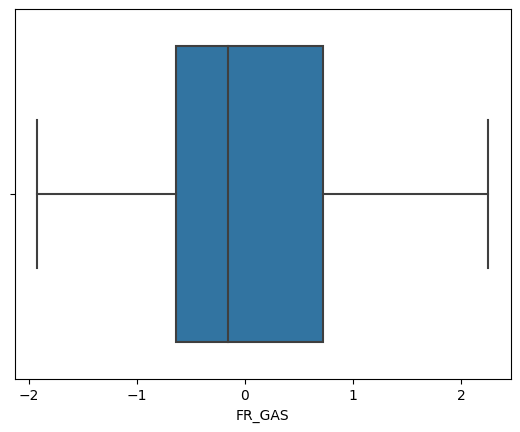

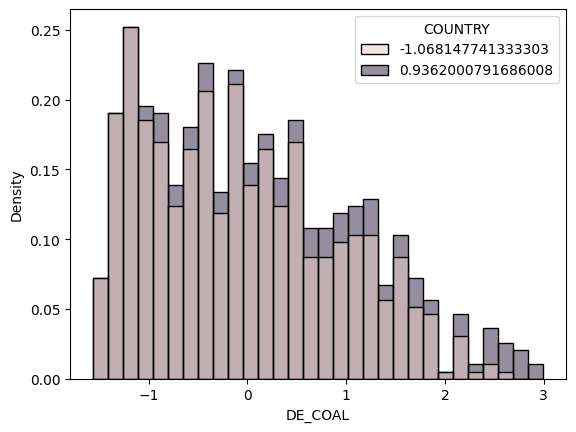

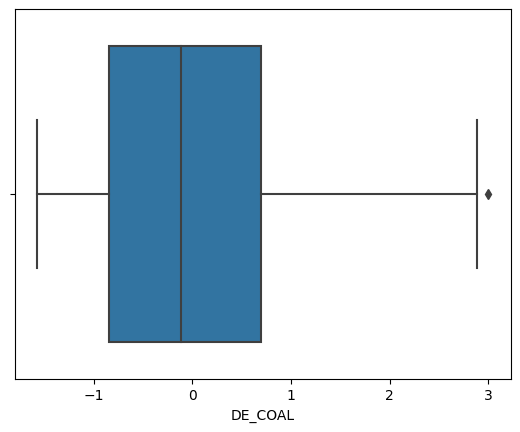

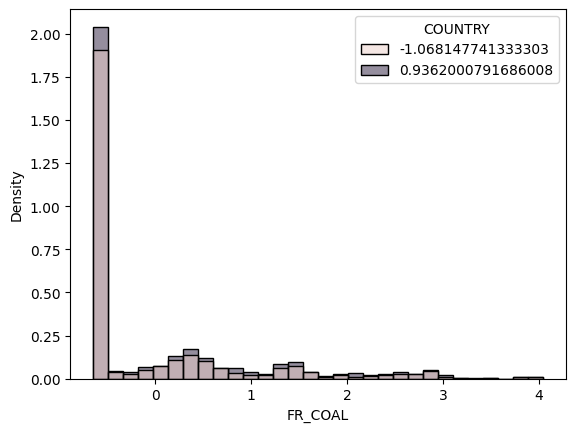

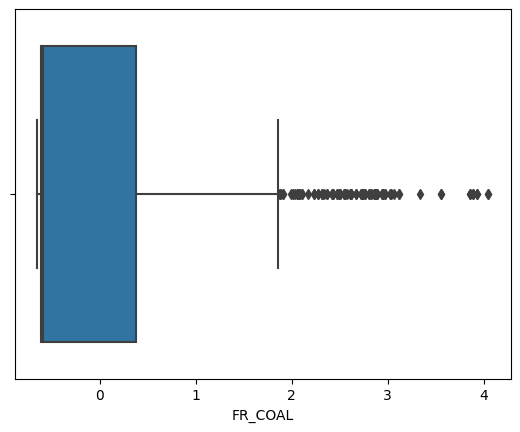

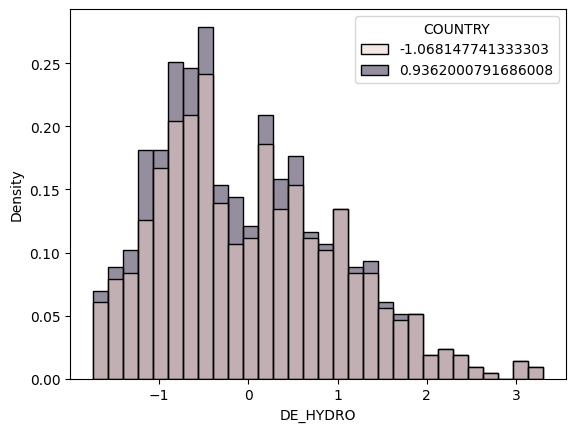

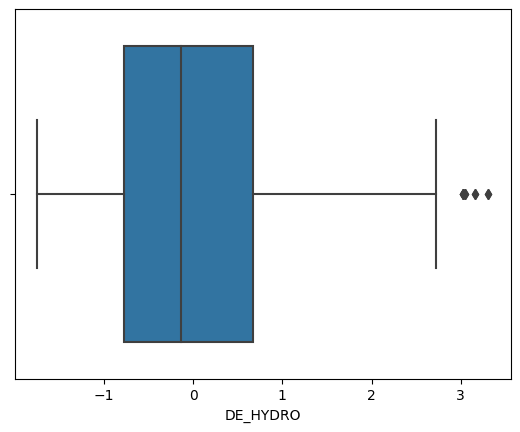

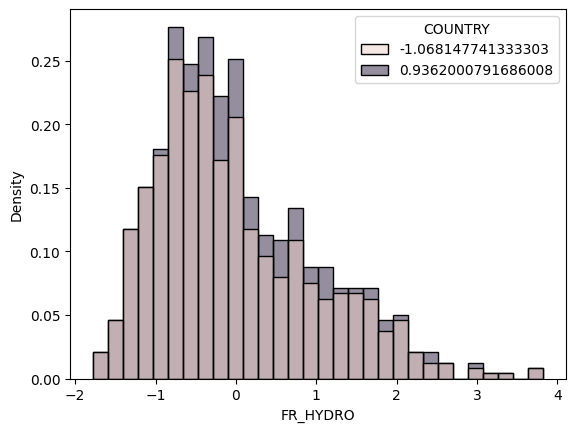

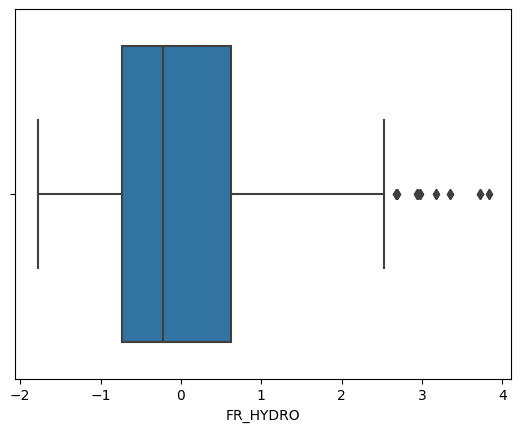

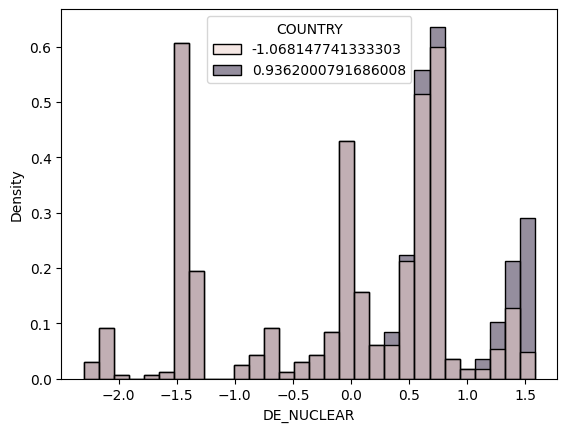

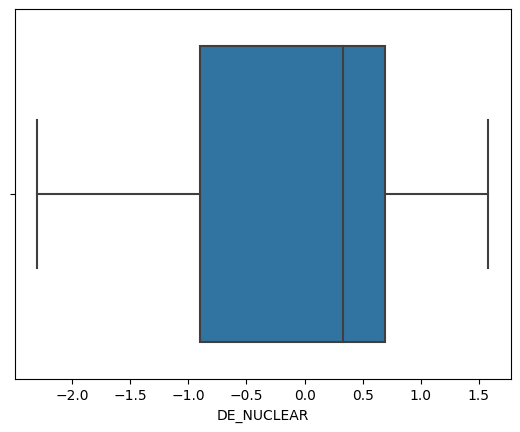

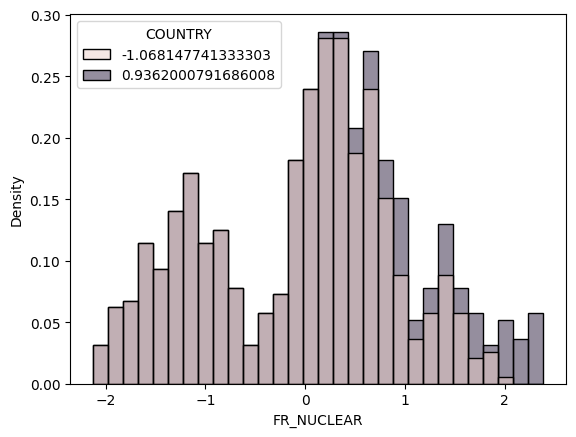

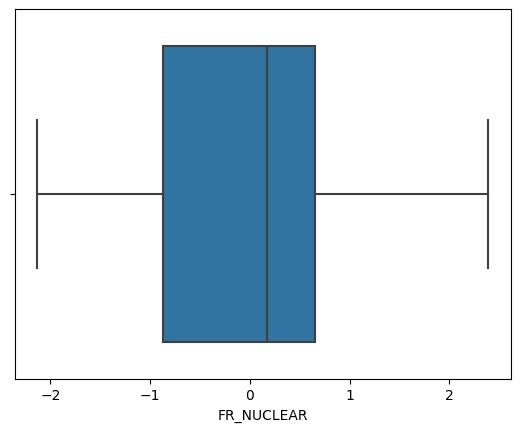

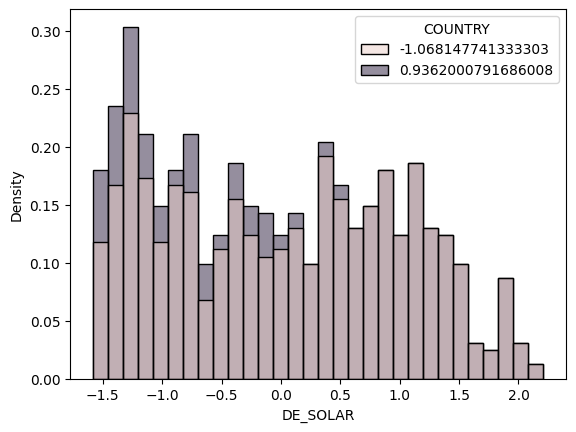

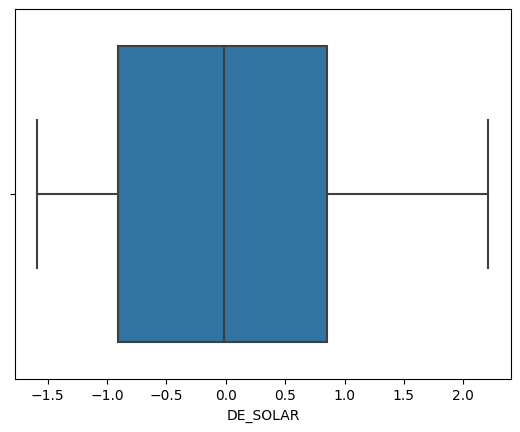

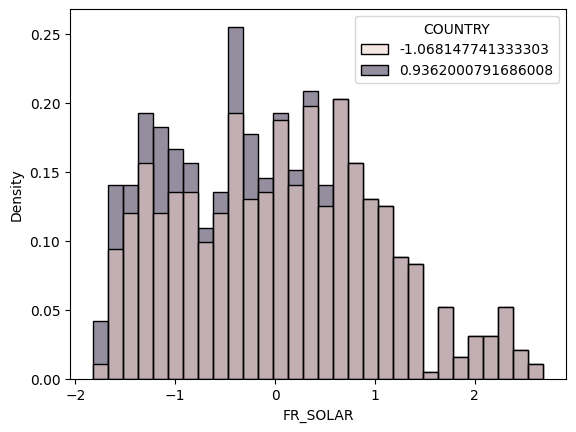

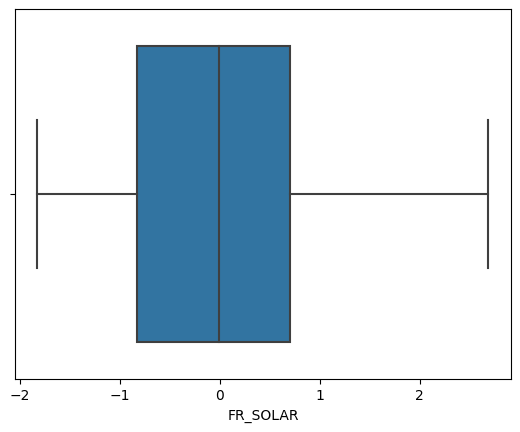

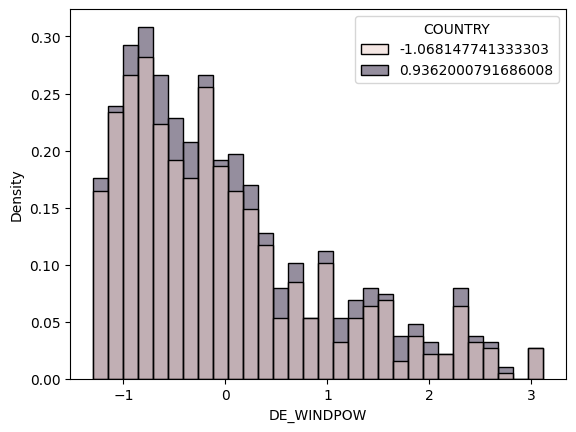

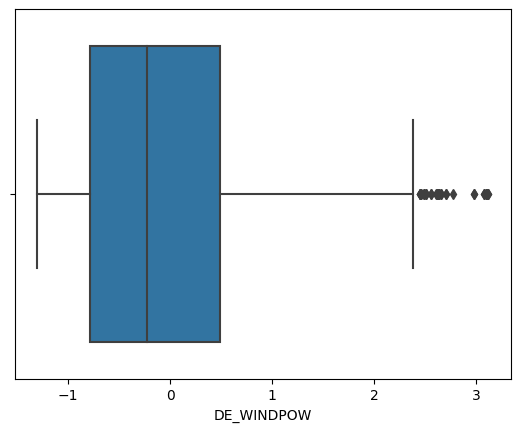

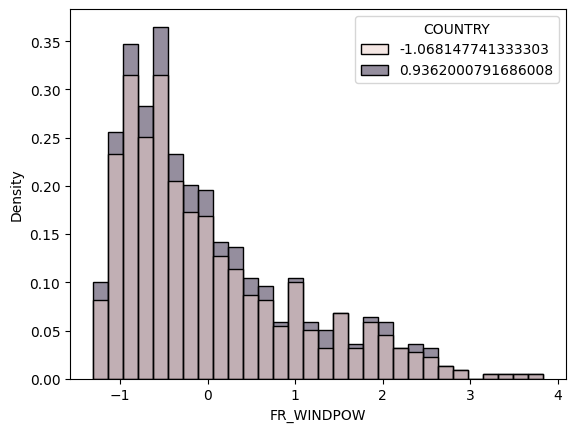

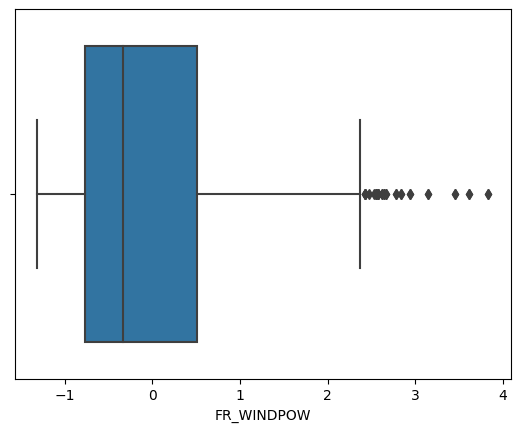

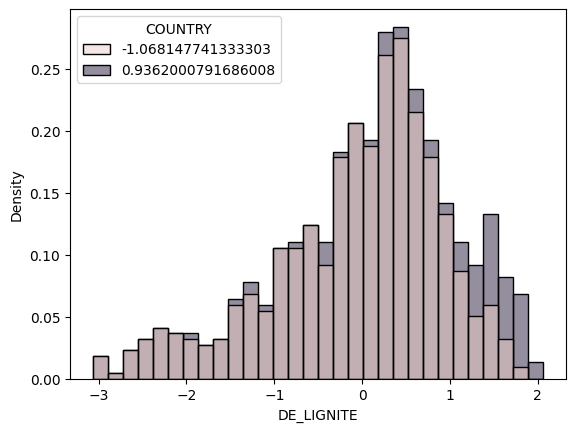

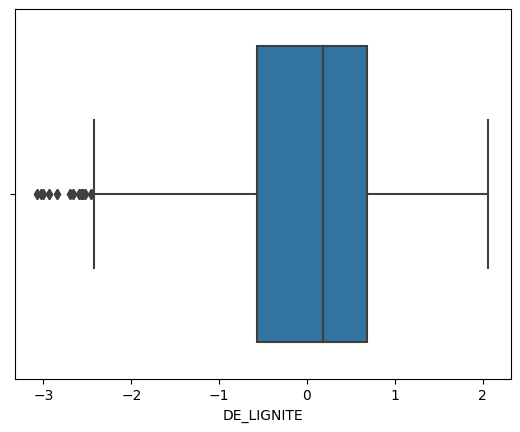

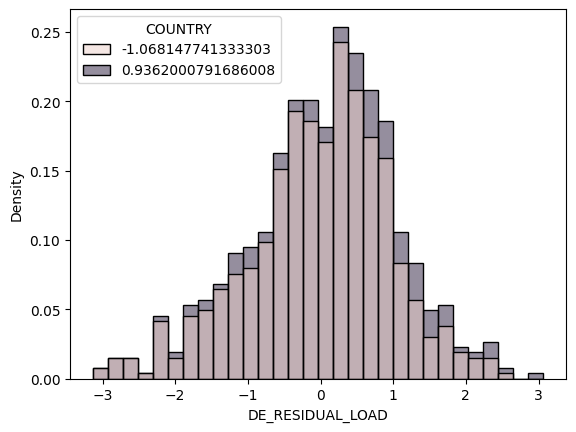

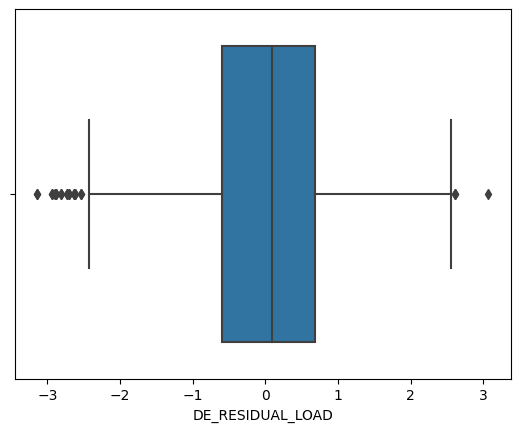

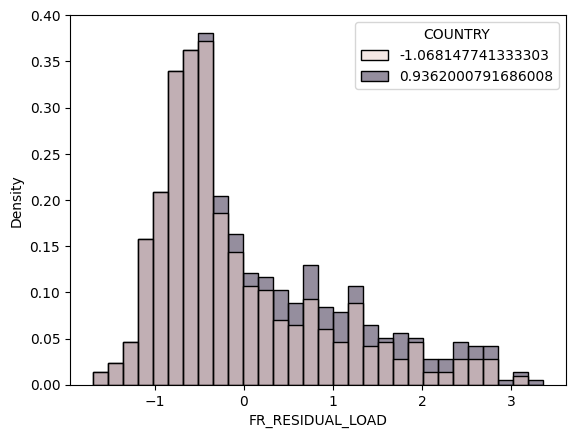

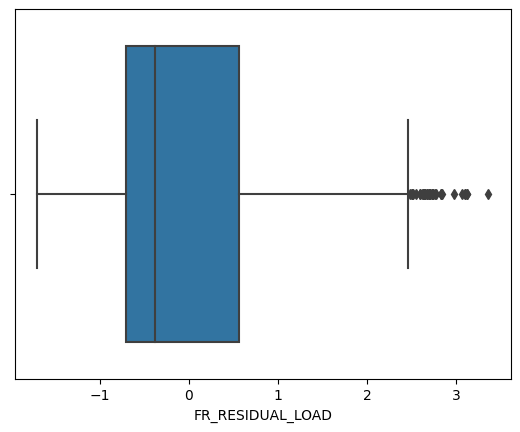

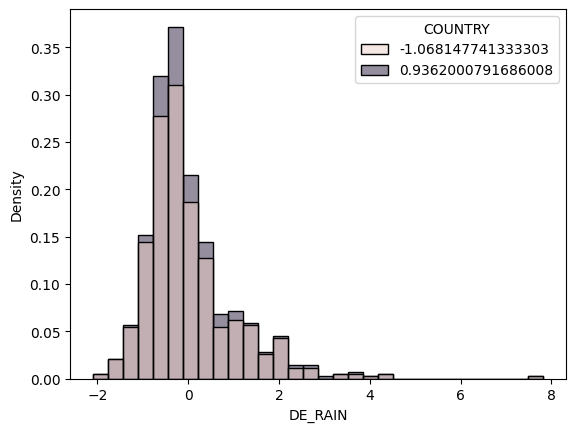

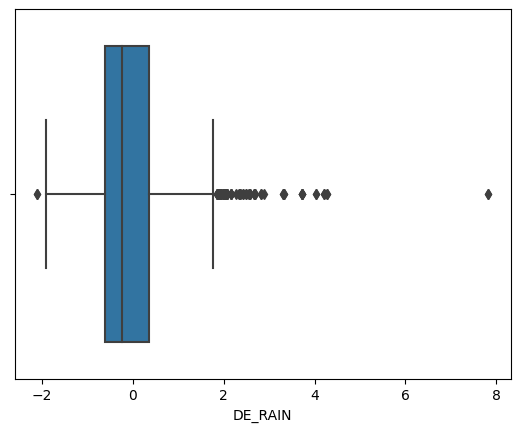

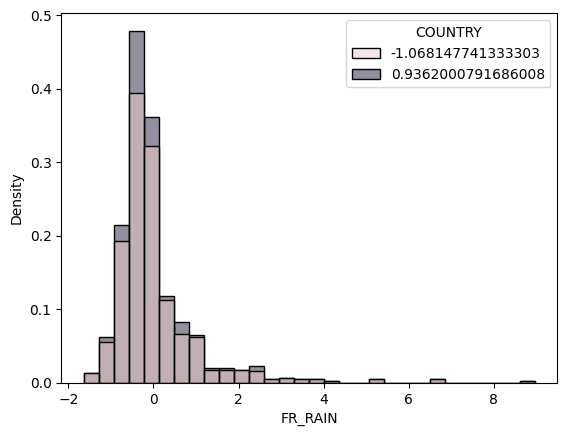

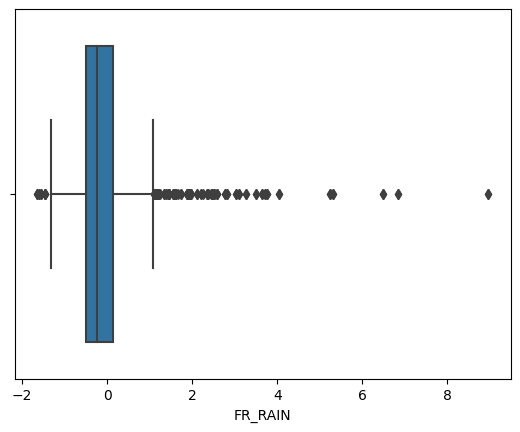

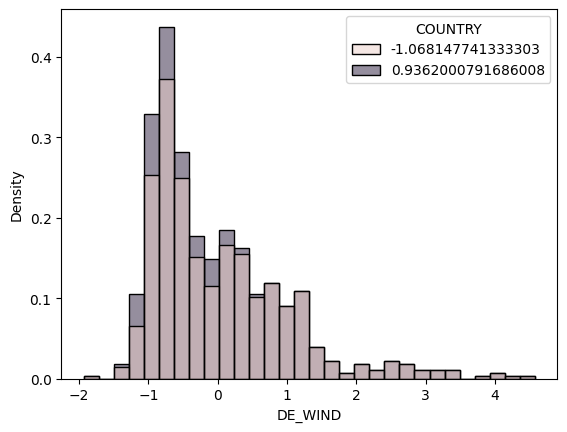

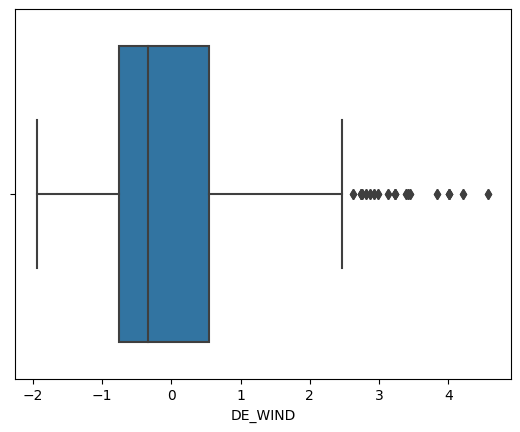

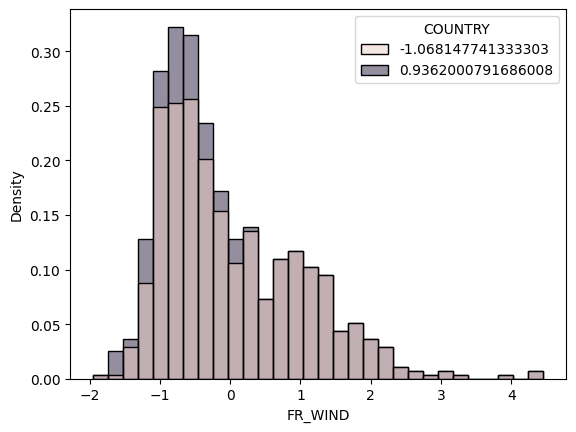

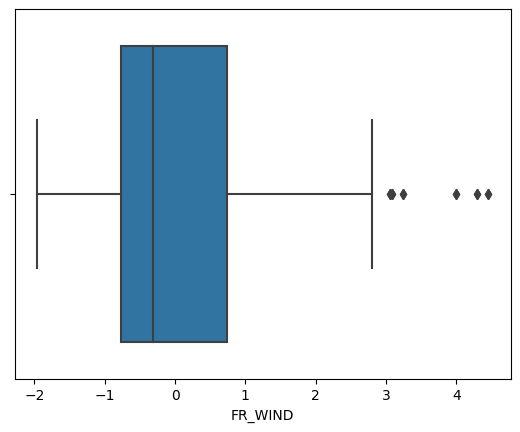

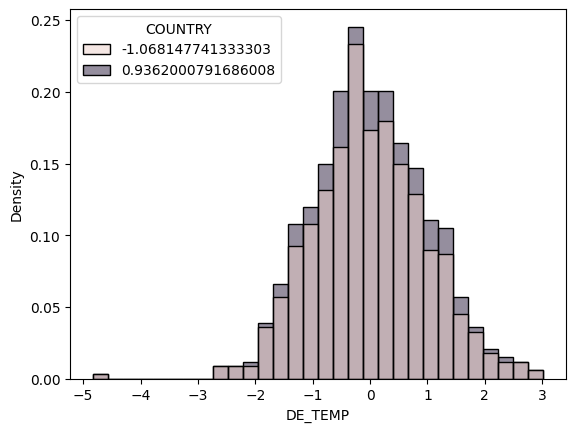

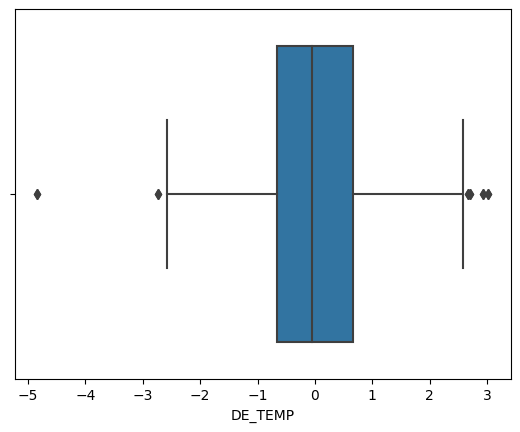

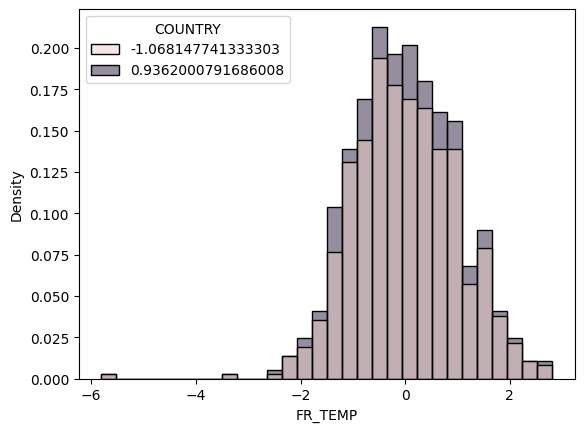

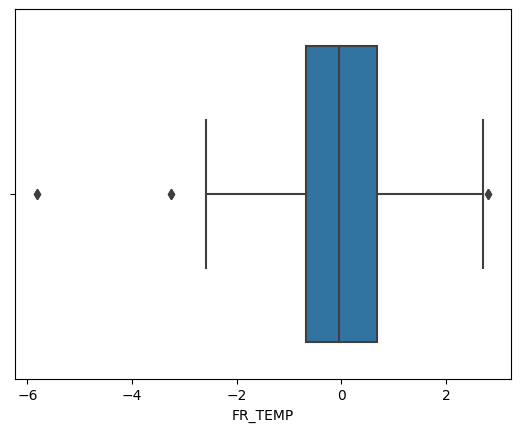

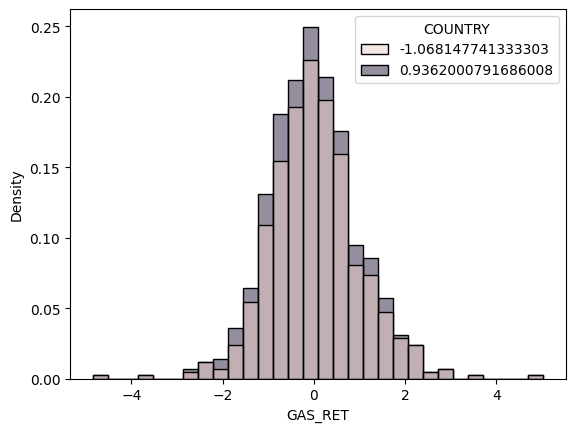

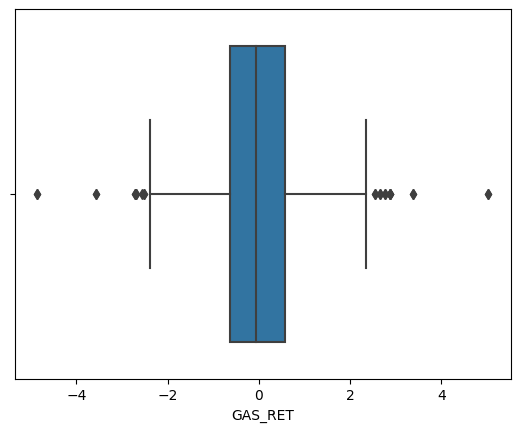

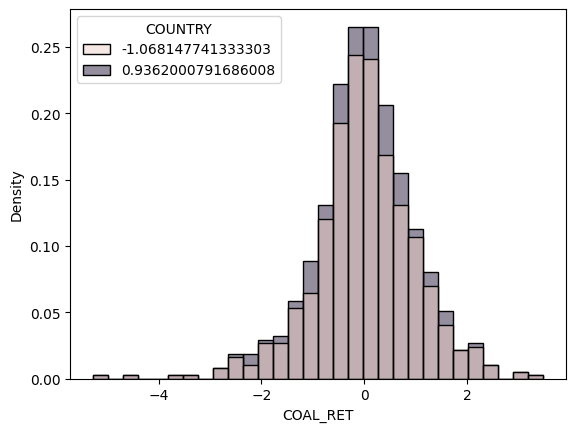

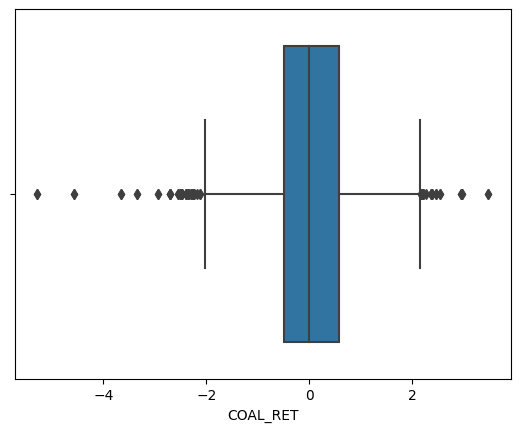

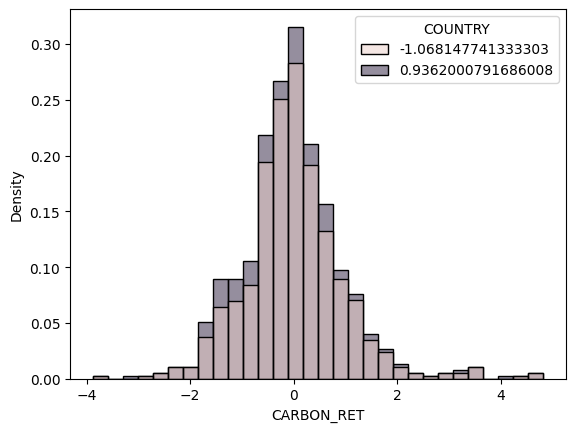

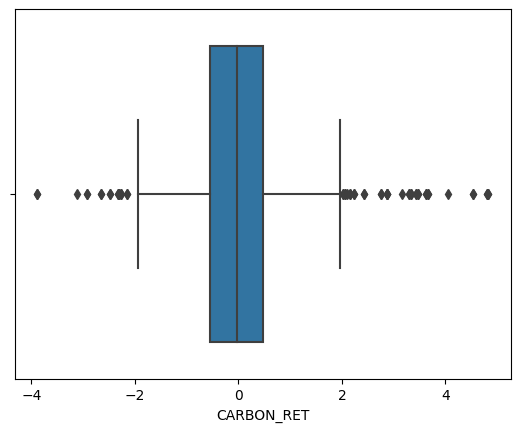

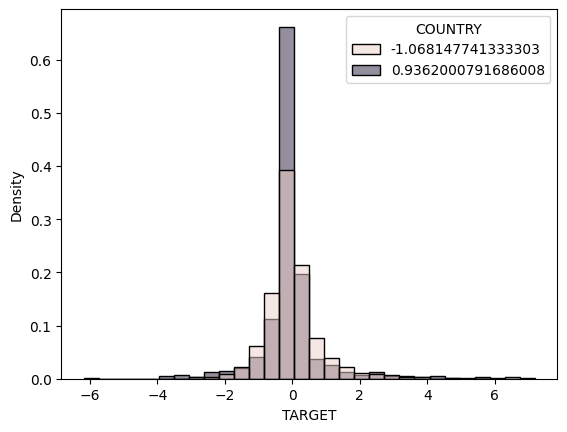

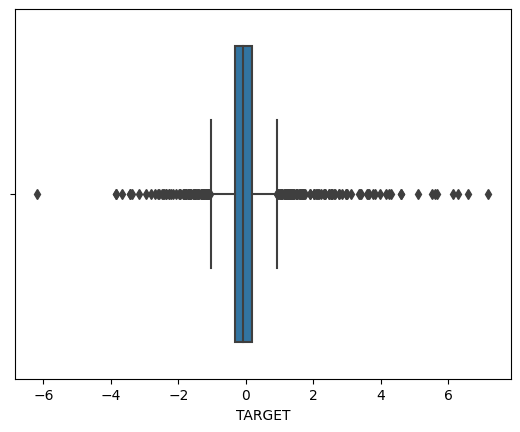

In [239]:
#Plot the density and  of each columns by country

for col in df.columns:
    sns.histplot(x=col, hue='COUNTRY', data=df, bins=30, stat="density")
    plt.show()
    sns.boxplot(x=col, data=df)
    plt.show()


<Axes: >

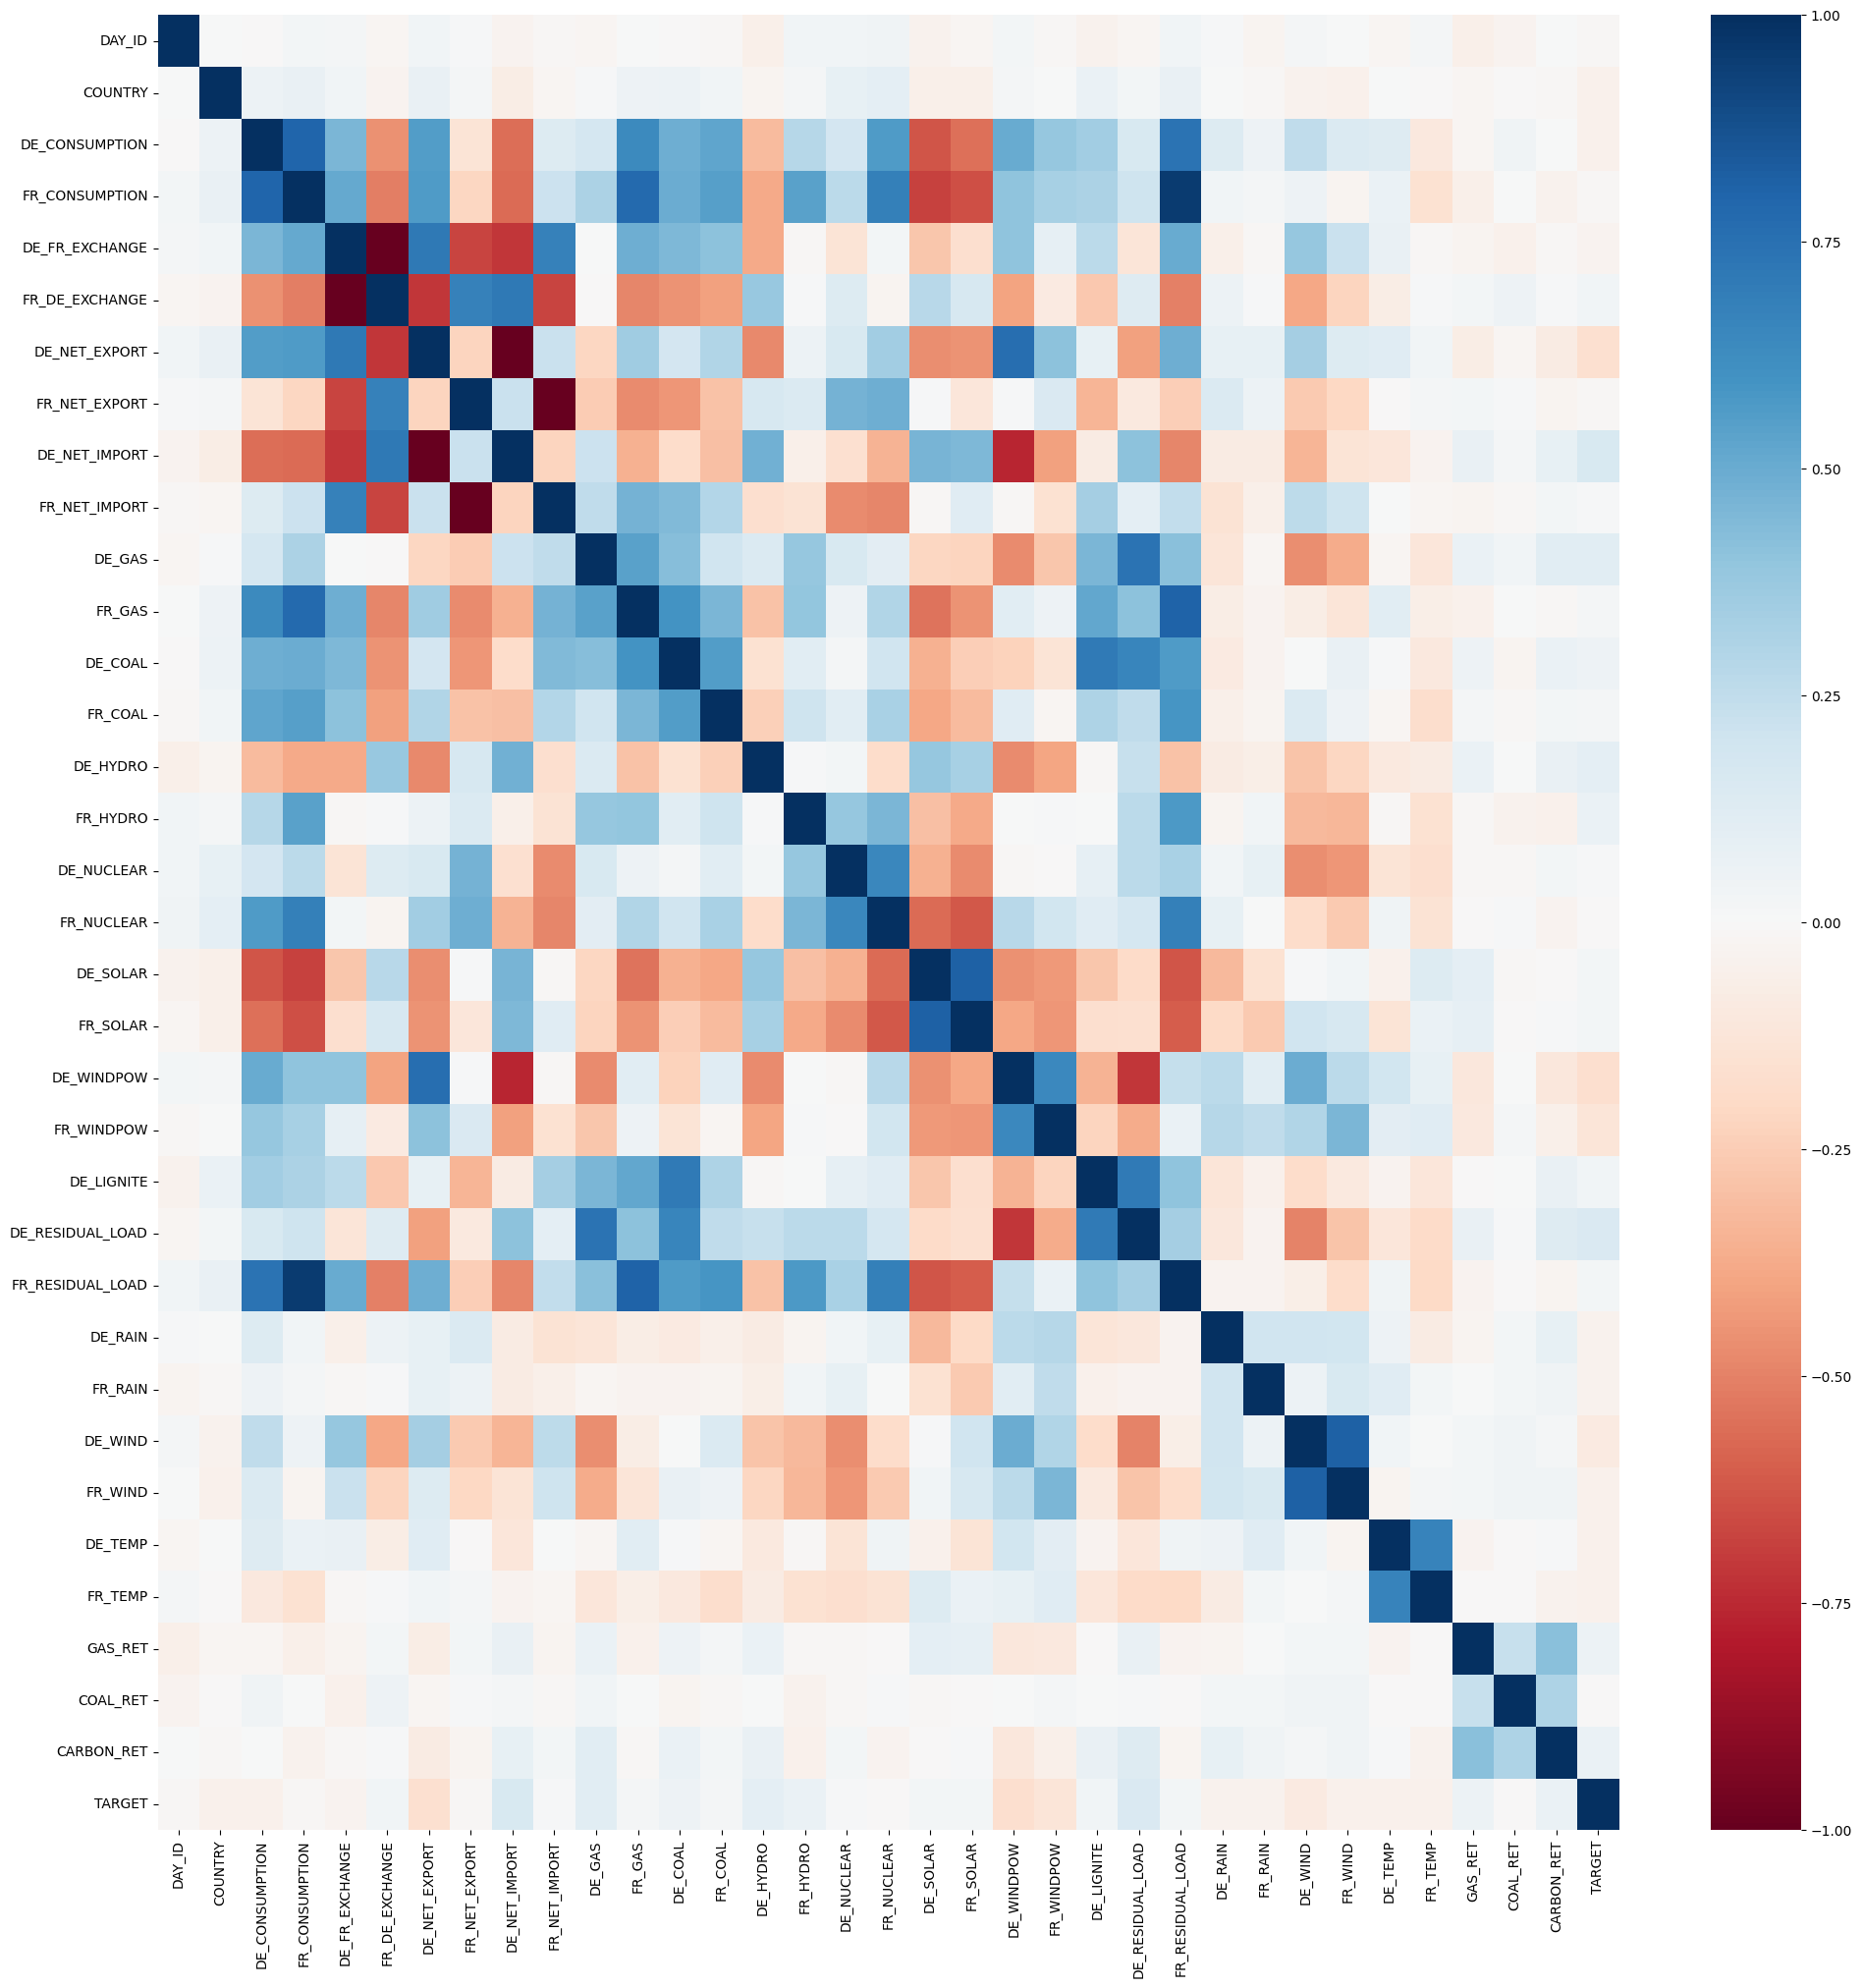

In [240]:
# Plot correlation matrix with heatmap

plt.figure(figsize=(24, 24))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='RdBu')

In [241]:
# Print each column correlation with each other
treashold = 0.75
variable_seen = []
highest_correlation = []
for i in df.columns:
    for j in df.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and (df[i].corr(df[j]) > treashold or df[i].corr(df[j]) < -treashold) and i != 'TARGET' and j != 'TARGET':
                print("{:>20} <---> {:<20} :  {}".format(i, j, df[i].corr(df[j])))
                highest_correlation.append(i)


      DE_CONSUMPTION <---> FR_CONSUMPTION       :  0.8000247966026744
      FR_CONSUMPTION <---> FR_GAS               :  0.7810476807964117
      FR_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.9608380589254399
      DE_FR_EXCHANGE <---> FR_DE_EXCHANGE       :  -0.9999999999999998
       DE_NET_EXPORT <---> DE_NET_IMPORT        :  -0.9999999999999998
       DE_NET_EXPORT <---> DE_WINDPOW           :  0.7611406500398217
       FR_NET_EXPORT <---> FR_NET_IMPORT        :  -1.0
       DE_NET_IMPORT <---> DE_WINDPOW           :  -0.7611406500398217
              FR_GAS <---> FR_RESIDUAL_LOAD     :  0.8080327645909665
            DE_SOLAR <---> FR_SOLAR             :  0.8130806182049253
             DE_WIND <---> FR_WIND              :  0.8151382177312319


##### Interpretation of correlations

What we can deduce is that the french and german's consumption is extremely linked, with a correlation of 80%.
We can also see that the french consumption is linked to the gas consumption at 78%, so french electricity depends on gas a lot.
The more the french consumption augments, the more they use the residual load, because there aren't enough renewable energies. We can also see that the residual load is mostly constitued by gas.
Germans export a lot of wind energy.

When french's solar energy is high, the german's solar energy is high too, most likely because the two countries are close and subject to the same weather conditions.

### Data Correcion

In [242]:
# Delete columns with high correlation

df = df.drop(highest_correlation, axis=1)
df_original = df.copy()

In [243]:
# Keep 5 most correlated columns with target column and delete the others

# corr_target = abs(df.corr()['TARGET'])

# print(corr_target.sort_values(ascending=False))

# df = df.drop(corr_target.sort_values(ascending=False)[10:].index, axis=1)

# # Print the 5 most correlated columns with target column

# plt.figure(figsize=(24, 24))
# sns.heatmap(df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)


In [244]:
# Deal with outliers by imputing them with bondaries except for the target column

for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    



### Data Analysis

In [245]:
# Fit a model and plot the evolution of the train and test scores with the hyperparameter

def fit_and_vary_hyperparameters(regressor, param_grid, X, y):
    grid = GridSearchCV(estimator=regressor, 
                        param_grid=param_grid, 
                        cv=KFold(n_splits=8, 
                                shuffle=True, 
                                random_state=int(perf_counter ()*100)
                                ),     
                        scoring=['neg_mean_squared_error', 'r2'], 
                        n_jobs=-1,
                        verbose=2,
                        return_train_score=True,
                        refit='neg_mean_squared_error'
                        )
    
    grid.fit(X, y)

    print("Best score: {}".format(-grid.best_score_))
    print("Best r2 score: {}".format(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    print("Best parameters: {}".format(grid.best_params_))
  

    # Plot the evolution of the train and test scores with the hyperparameter for each metric with the best parameters

    data = pd.DataFrame(grid.cv_results_)
    
    for param in param_grid:
        data_to_plot = data.copy()

        # Go through each hyperparameter and delete all the line where the other parameter are not the best

        for other_param in param_grid:
            if other_param != param:
                data_to_plot = data_to_plot[data_to_plot['param_' + other_param] == grid.best_params_[other_param]]

        # Check if the hyperparameter is a list of numbers or a list of strings
        if type(param_grid[param][0]) == int or  type(param_grid[param][0]) ==float or  type(param_grid[param][0]) ==np.float64:
            param_to_plot = param_grid[param]
        else:
            print(type(param_grid[param][0]))
            param_to_plot = [str(i) for i in param_grid[param]]

        plt.figure(figsize=(12,4))
        plt.plot(param_to_plot, -data_to_plot['mean_train_neg_mean_squared_error'], label='Train')
        plt.plot(param_to_plot, -data_to_plot['mean_test_neg_mean_squared_error'], label='Test')
        plt.xlabel(param)
        plt.ylabel('mean_squared_error')
        plt.legend()
        plt.show()

    return grid
    

In [246]:
# Split data

X = df.copy().drop(['TARGET'], axis=1)
y = df['TARGET']

models = {}

##### Linear Regression

Fitting 8 folds for each of 2 candidates, totalling 16 fits
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_inte

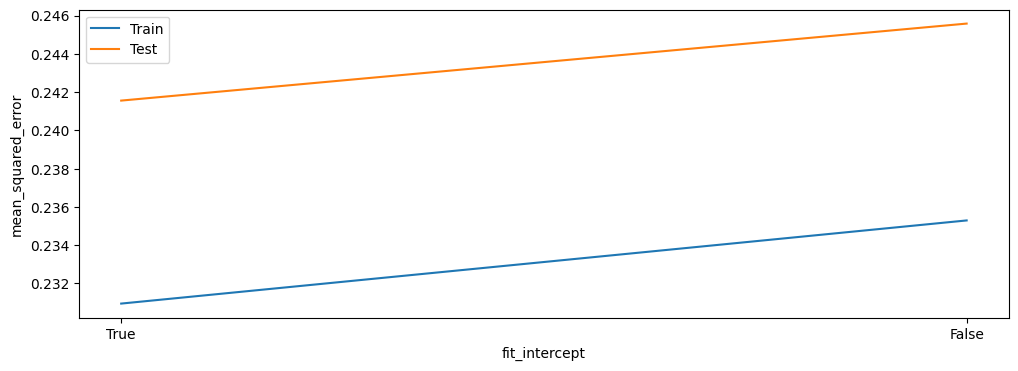

In [247]:
# Linear regression

models["linear_regression"]= fit_and_vary_hyperparameters(LinearRegression(), {'fit_intercept': [True, False]}, X, y)


##### Regularized Linear Regression

Fitting 8 folds for each of 50 candidates, totalling 400 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................alpha=0.00013257113655901095; total time=   0.0s
[CV] END .......................alpha=0.00013257113655901095; total time=   0.0s
[CV] END .......................alpha=0.00013257113655901095; total time=   0.0s
[CV] END .......................alpha=0.0001325

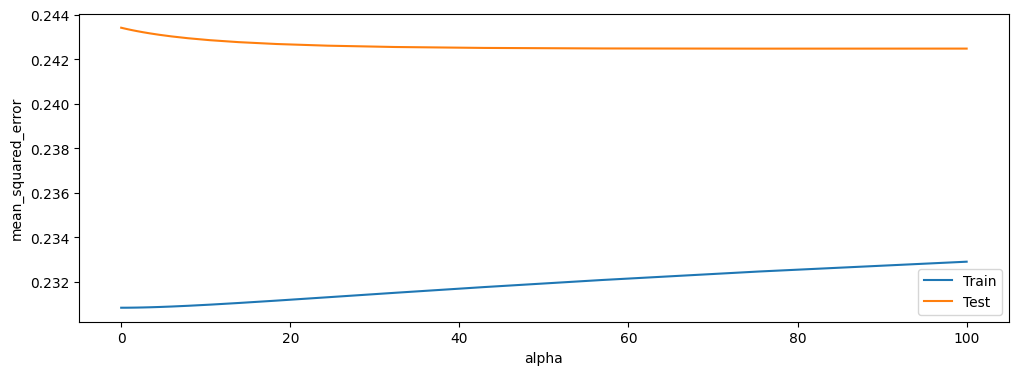

In [248]:
# RIDGE Regression
hyperparameters = {
    'alpha': np.logspace(-4, 2),
}

models["ridge"] = fit_and_vary_hyperparameters(Ridge(), hyperparameters, X, y)


Fitting 8 folds for each of 50 candidates, totalling 400 fits
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END .......................alpha=1.2067926406393289e-05; total time=   0.0s
[CV] END .......................alpha=1.2067926406393289e-05; total time=   0.0s
[CV] END .......................alpha=1.2067926406393289e-05; total time=   0.0s
[CV] END .......................alpha=1.2067926

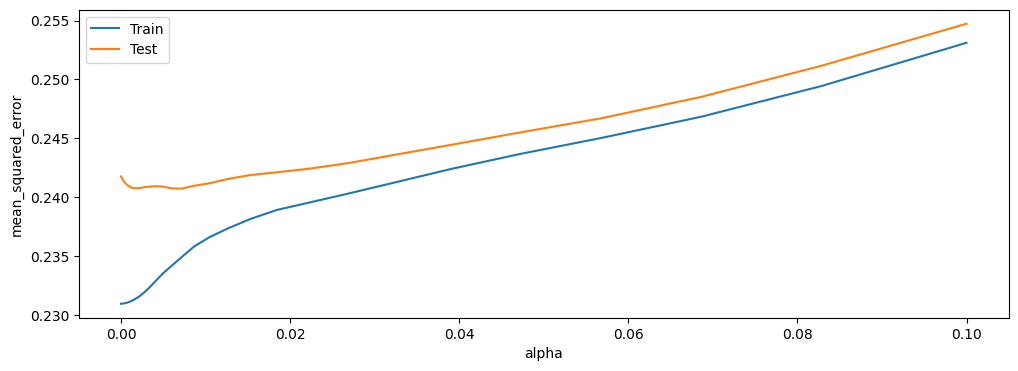

In [249]:
# Lasso Regression
hyperparameters = {
    'alpha': np.logspace(-5, -1),
}

models["lasso"] = fit_and_vary_hyperparameters(Lasso(max_iter=5000), hyperparameters, X, y)

##### K-Nearest Neighbors

Fitting 8 folds for each of 58 candidates, totalling 464 fits
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=10; total time=   0.1s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n_neighbors=15; total time=   0.0s
[CV] END .....................................n

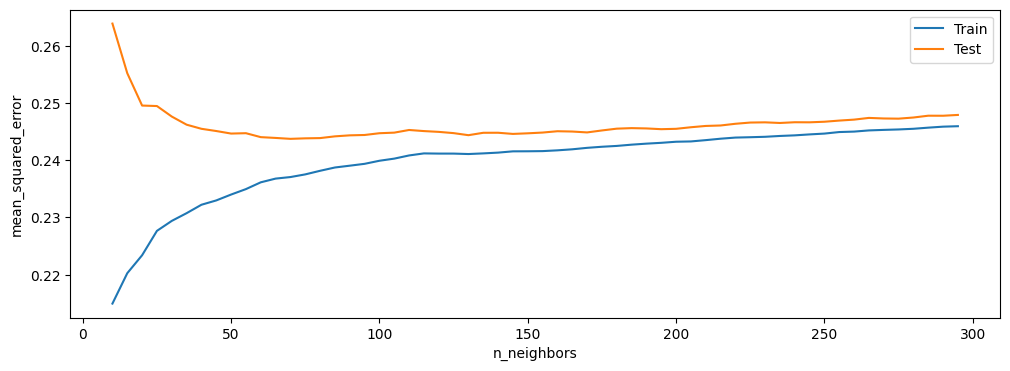

In [250]:
# KNN Regression
hyperparameters = {
    'n_neighbors': range(10, 300, 5),
}

models["knn"] = fit_and_vary_hyperparameters(KNeighborsRegressor(), hyperparameters, X, y)
 

##### Decision Tree

Fitting 8 folds for each of 49 candidates, totalling 392 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ......................................

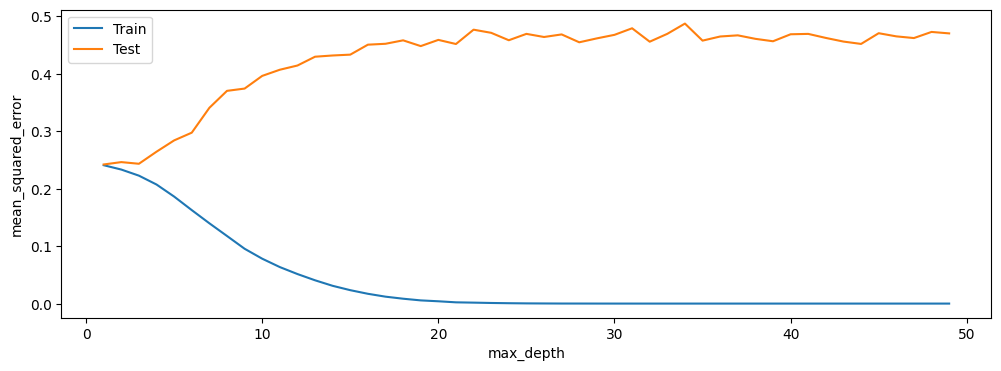

In [251]:
# Decision Tree Regression with different depth

hyperparameters = {
    'max_depth': range(1, 50, 1),
}

models["decision_tree"] = fit_and_vary_hyperparameters(DecisionTreeRegressor(), hyperparameters, X, y)

##### Random Forest

Fitting 8 folds for each of 100 candidates, totalling 800 fits
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.7s
[CV] END ..................max_depth=1, min_samples_split=30; total time=   0.5s
[CV] END ..................max_depth=1, min_samples_split=30; total time=   0.5s
[CV] END ..................max_depth=1, min_samples_split=30; total time=   0.5s
[CV] END ..................max_depth=1, min_sa

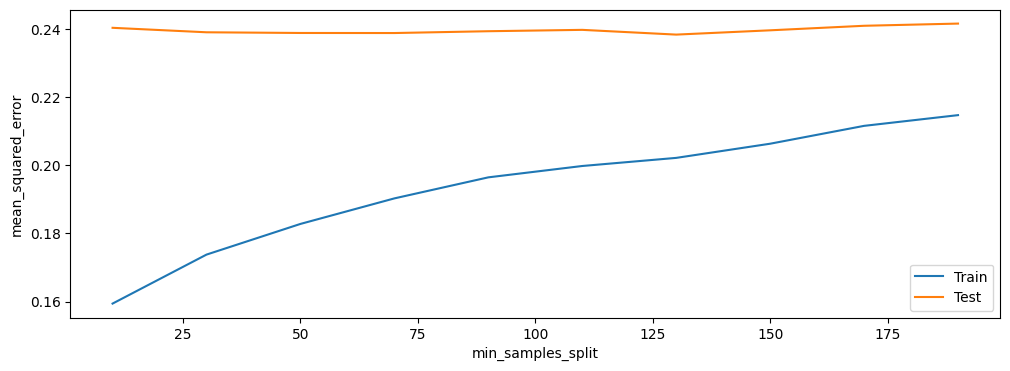

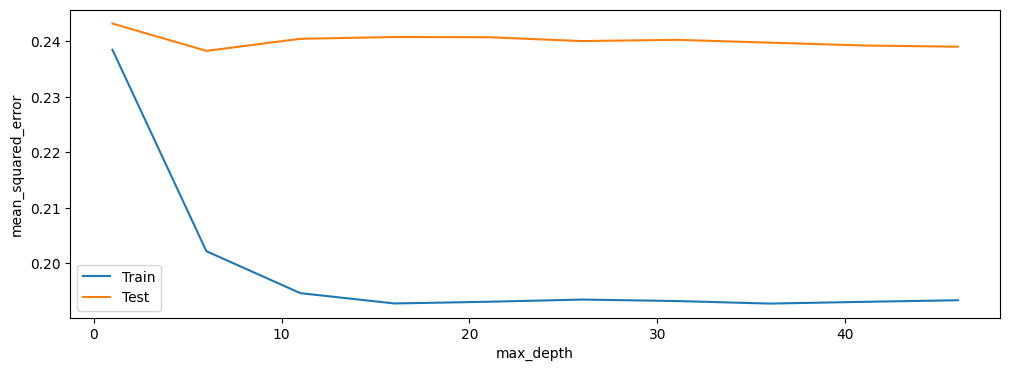

In [252]:
# Random Forest Regression

hyperparameters = {
    'n_estimators': range(10, 200, 25),
    'min_samples_split': range(10, 200, 20),
}

models["random_forest"] = fit_and_vary_hyperparameters(RandomForestRegressor(), hyperparameters, X, y)

##### Neural Network

In [253]:
# Neural Network Regression with cross validation

# hyperparameters = {
#     'hidden_layer_sizes': [(100), (100, 100)],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
# }

# models["neural_network"] = fit_and_vary_hyperparameters(MLPRegressor(max_iter=2000), hyperparameters, X, y)


### Ranking of the models

Text(0, 0.5, 'spearman_corr')

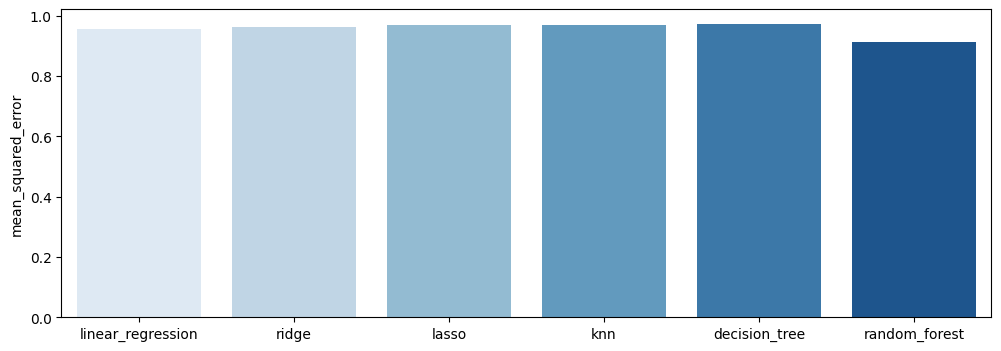

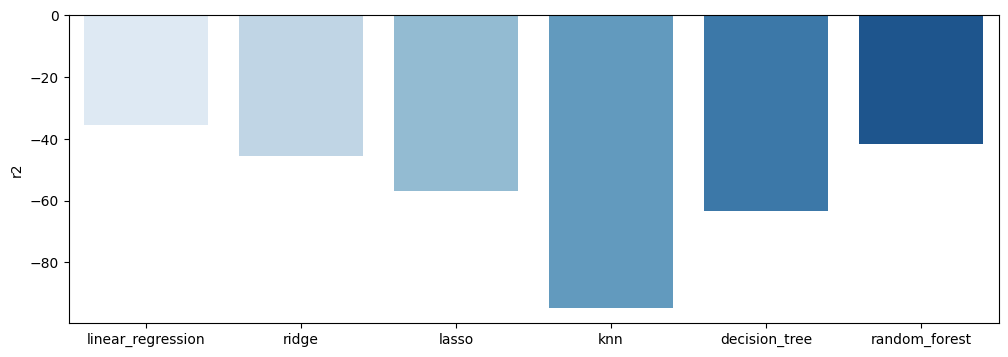

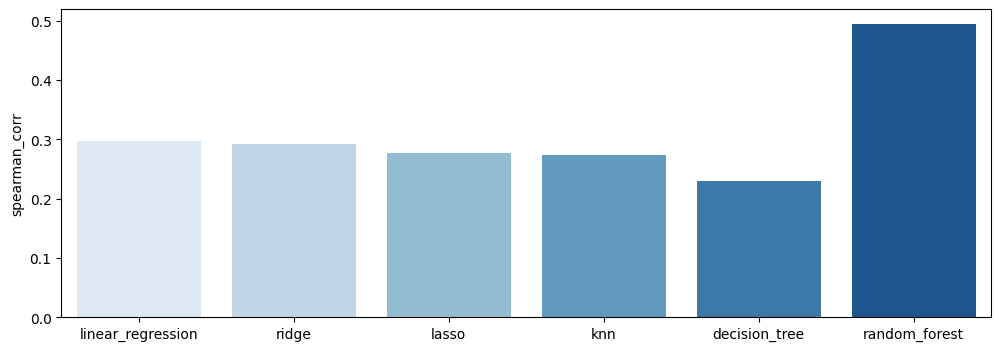

In [254]:
# Plot each model r2, mean error and spearman corr in a bar plot with sns for df_original

X = df_original.copy().drop(['TARGET'], axis=1)
y = df_original['TARGET']

spearman_corr = {}
mean_squared_error = {}
r2 = {}
for model in models:
    spearman_corr[model] = stats.spearmanr(models[model].predict(X), y)[0]
    mean_squared_error[model] = metrics.mean_squared_error(models[model].predict(X), y)
    r2[model] = metrics.r2_score(models[model].predict(X), y)

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[mean_squared_error[model] for model in models], palette='Blues')
plt.ylabel('mean_squared_error')

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[r2[model] for model in models], palette='Blues')
plt.ylabel('r2')

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[spearman_corr[model] for model in models], palette='Blues')
plt.ylabel('spearman_corr')

    

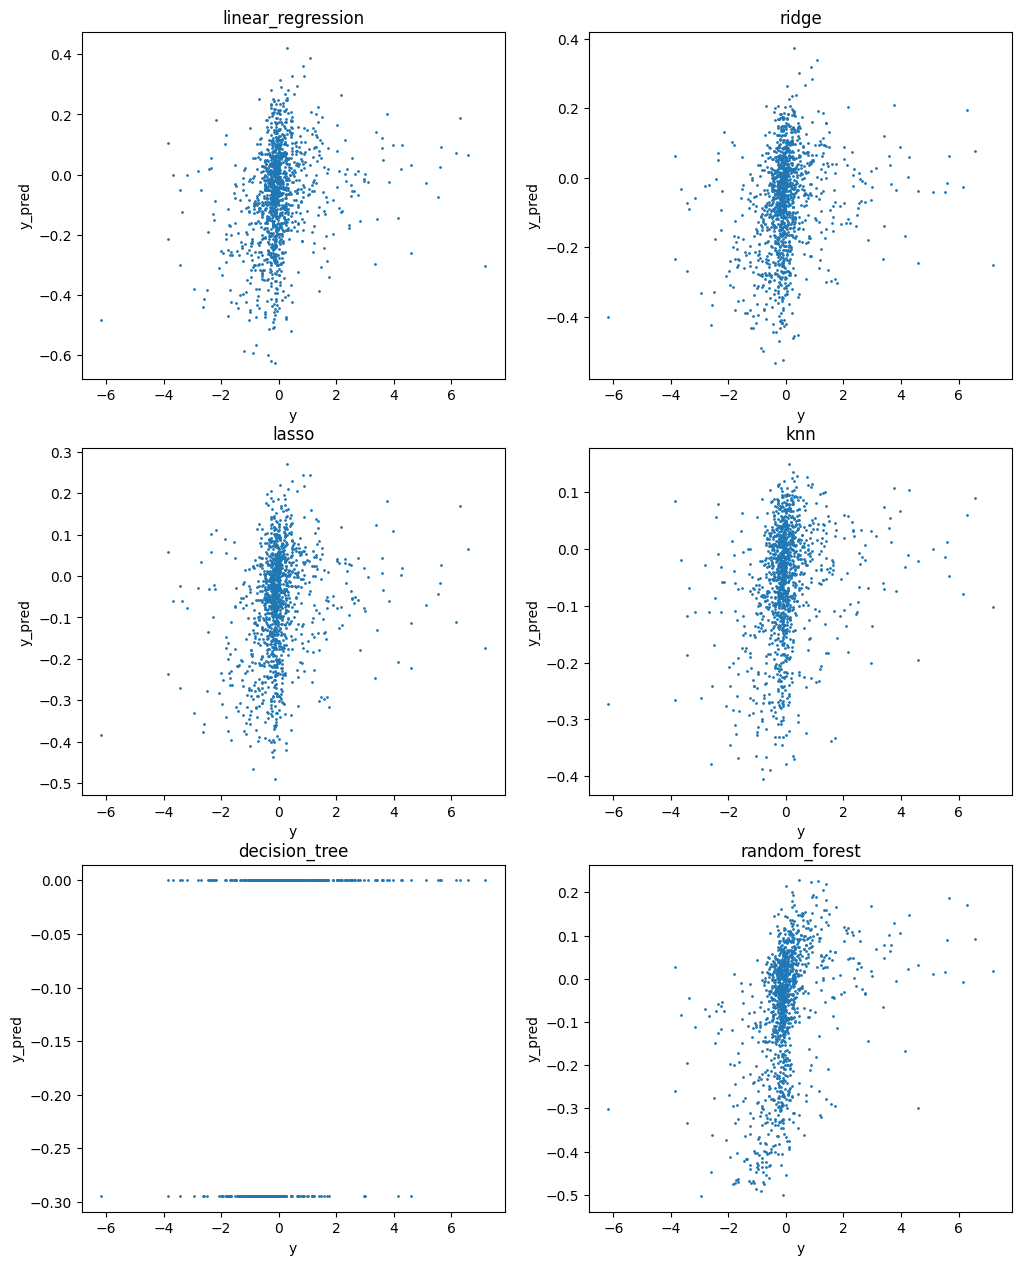

In [255]:
# Plot y and y_pred for each model in a scatter subplot

plt.figure(figsize=(12, 64))

for i, model in enumerate(models):
    plt.subplot(12, 2, i+1)
    plt.scatter(y, models[model].predict(X), s=1)
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title(model)
plt.show()
